# Assignment 2
#### Arindam Patra (MDS202008) ,   Aditi Kundu (MDS202002)


# Here we have used the following libraries.
1. Pandas
2. Numpy
3. Matplotlib.pyplot
4. Seaborn
5. %matplotlib.inline.


Then we have created a dictionary "D", where keys are docID and values are list of wordID present in that document.

Now we form another dictionary "dic", which contains docID as keys, and it takes a values as a list of length = number of elements in vocab + 1, (where the zero-th place will be a garbage value and we will not consider it).
If a docID contains a certain wordID, then the wordID-th place in the list will be 1, the the other values will be zero.
Loosely, we are making a list, where if a Document contains a certain word then the index of the word in the list will contain 1 as value, and if the word is not present in the document then the corresponding index will contain 0 in the list.

Then we are defining Jaccard distance function in "jaccard_distance", which will take two list as input and will return their jaccard distance.

Then we compute a nested dictionary, namely "jaccard_matrix". Where each document will form a key, and corresponding to each key we have another dictionary as value. In this dictionary the keys will be each document and its value will be the corresponding jaccard distance. Here we are storing the jaccard distance between each document pairs. Basically we are forming the jaccard distance matrix in the form of dictionary to save space.

Now we will define "cluster_func1", which will take the centroids in the form of list and then form the corresponding clusters. It will give a dictionary as an output, where the keys will be the centroids and the list of elements of the corresponding cluster as the value.

Now we will initialize centroids. Usually in k-means we initialize centroids randomly, but here we will follow a heuristic way. At first we will take the sum of the values of the jaccard matrix corresponding to each docID. Then we will take the highest k- values. And then choose the corresponding keys as initial centroids. Now we are following this way so that the centroids are fairly far from each other. 

Then we will form initial clusters using the previous cluster function "cluster_func1" on this centroids.

Now we will update our centroids and then form the clusters corresponding to them iteratively. 

In each loop, from every cluster, we are updating the centroid by setting up a threshold. At first, for cluster we are taking the element of the cluster and corresponding to those elements we are taking the previous "dic" dictionary and we are adding up the values for those elements. Then we are dividing each element in that list with the number of elements in that specific cluster. 
Now the values of this list will lie between 0 to 1. Then we will set a threshold and accordingly replace the values less than the threshold by 0 and greater than the threshold by 1. This can be said as a dummy centroid. Then we choose the nearby(by jaccard distance) document of this dummy centroid and take it as the new centroid. continuing this process, we will get our all the k centroids, and then again we calculate the new clusters and again evaluate the new centroids iteratively. 

Now we will calculate the inertia of the clusters corresponding to each k and finally plot it on a elbow graph and from that decide upon the most optimized k.

**Output file link:** https://drive.google.com/drive/folders/1G2BtwC2RhaXqItABfzX1VPjsL4UDuSmr?usp=sharing

In [18]:
### Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('vocab.nips.txt',names=['vocab'])   ##importing vocab data
df1=pd.read_csv('docword.nips.txt',sep=' ',names=['docID' ,'wordID','count'],skiprows=[0,1,2]) ##importing docword data

In [3]:
df1.shape

(746316, 3)

In [4]:
df.head()

,vocab
0,a2i
1,aaa
2,aaai
3,aapo
4,aat


In [5]:
df.shape

(12419, 1)

In [6]:
df1.head()

,docID,wordID,count
0,1,2,1
1,1,39,1
2,1,42,3
3,1,77,1
4,1,95,1


In [20]:
%%time
### Keys are docID and values are list of wordID present in that doc
D={}
for i in range(1,max(df1['docID'])+1):
    D[i]=list(df1[df1['docID']==i]['wordID'])

Wall time: 2.35 s


In [8]:
%%time
#### Here Keys are docID and values are 0 or 1. If a wordID is there then in that position we will put 1.
dic={}
for i in range(1,max(df1['docID'])+1):
    dic[i]=[0]*(len(df)+1)          
    ##generating a list of zeros where total number of element is equal to distinct word in the vocabulary
    
    
for i in D.keys():
    le=len(D[i])
    ## 'le' is the number of word present in an document
    for j in range(le):
        word=D[i][j]
        dic[i][word]=1

Wall time: 468 ms


In [9]:
### Calculating the jaccard distance between two docs.
def jaccard_distance(doc1, doc2):
    doc1=set(doc1)
    doc2=set(doc2)
    intersection_len = len(doc1.intersection(doc2))
    union_len = len(doc1) + len(doc2) - intersection_len
    return 1-(intersection_len / union_len)

In [13]:
%%time
### Creating a jaccard matrix as a dictionary.
jaccard_matrix={}
for i in range(1,max(df1['docID'])+1):
    jaccard_matrix[i]={}
    for j in range(1,max(df1['docID'])+1):
        if j not in jaccard_matrix:
            jaccard_matrix[j]={}
        Distance = jaccard_distance(D[i],D[j])
        jaccard_matrix[i][j]=Distance
        jaccard_matrix[j][i]=Distance

Wall time: 4min 8s


In [14]:
### Defining the cluster function
def cluster_func1(centroid):
    cluster={}
    for cen in centroid:
        cluster[cen]=[]
    for i in jaccard_matrix:
        min_similarity=np.inf
        c=-1
        for j in centroid:
            if jaccard_matrix[j][i]<min_similarity:
                min_similarity=jaccard_matrix[j][i]
                c=j
        cluster[c].append(i)
    return(cluster)

In [21]:
%%time
inertia1=[]
for Num_of_clusters in range(1,15):
    ### TO initialize the centroids
    sum_of_jaccard_for_wordID={}
    for i in jaccard_matrix:
        sum_of_jaccard_for_wordID[i]=sum(jaccard_matrix[i].values())
    ### Taking highest 10 sums
    max_10_sum=sorted(list(sum_of_jaccard_for_wordID.values()),reverse=True)[:Num_of_clusters]
    initial_centroid=[]
    for j in jaccard_matrix:
        if sum_of_jaccard_for_wordID[j] in max_10_sum:
            initial_centroid.append(j)
    print(initial_centroid)
    #print(sum_of_jaccard_for_wordID) 
    
    cluster=cluster_func1(initial_centroid)
    prev_centroids=initial_centroid
    new_centroids=[]
    for itr in range(10):
        if prev_centroids==new_centroids:  ## If the centroids are not changing then we won't iterate more.
            break
        prev_centroids=new_centroids
        prev_cluster=list(cluster.keys())
        new_centroids=[]
        for i in prev_cluster:
            cluster_element=cluster[i]
            total=[0]*(len(df)+1)
            for j in cluster_element:
                total += dic[j]       ### Adding up all list of a cluster
            avg = [x / len(cluster_element) for x in total]  ## Now we will get some fractional value
            for k in range(len(avg)):   ### Converting it only in 0 or 1
                if avg[k]>=0.05:
                    avg[k]=1
                else:
                    avg[k]=0
            elements=[]           ### Storing the wordID for that centroid of the cluster
            for l in range(len(avg)):
                if avg[l]==1:
                    elements.append(l)
    ### Now we will check which docID has best similarity with the calculated centroid.
    ### Best similarity docID wil be our new centroid
            min_index=np.inf
            center=-1
            for m in cluster_element:
                jac=jaccard_distance(D[m],elements)
                if jac<min_index:
                    min_index=jac
                    center=m
            new_centroids.append(center)
        print(new_centroids)
        cluster=cluster_func1(new_centroids)
        
    s=0
    for i in new_centroids:
        for j in cluster[i]:
            s=s+ jaccard_matrix[i][j]**2
    s=s/len(new_centroids) 
    inertia1.append(s)

[1104]
[1]
[1]
[1104, 1179]
[2, 1]
[2, 1]
[1104, 1179, 1217]
[2, 1, 3]
[2, 1, 3]
[1104, 1179, 1199, 1217]
[2, 1, 6, 3]
[2, 1, 6, 3]
[1104, 1120, 1179, 1199, 1217]
[2, 7, 1, 6, 3]
[2, 4, 1, 6, 3]
[2, 4, 1, 6, 3]
[1089, 1104, 1120, 1179, 1199, 1217]
[1, 40, 7, 4, 6, 33]
[1, 2, 7, 4, 6, 3]
[1, 2, 7, 4, 6, 3]
[1089, 1104, 1120, 1179, 1188, 1199, 1217]
[1, 40, 7, 9, 4, 6, 33]
[1, 2, 7, 5, 4, 6, 3]
[1, 2, 7, 5, 4, 6, 3]
[1089, 1104, 1120, 1139, 1179, 1188, 1199, 1217]
[1, 40, 7, 4, 30, 36, 115, 33]
[1, 2, 7, 4, 15, 25, 115, 3]
[1, 2, 7, 4, 15, 25, 115, 3]
[1089, 1104, 1120, 1139, 1179, 1183, 1188, 1199, 1217]
[1, 40, 7, 4, 73, 15, 36, 186, 33]
[1, 2, 7, 4, 41, 3, 25, 104, 27]
[1, 2, 7, 4, 41, 3, 25, 50, 6]
[1, 2, 7, 4, 41, 3, 25, 42, 6]
[1, 2, 7, 4, 41, 3, 25, 42, 6]
[954, 1089, 1104, 1120, 1139, 1179, 1183, 1188, 1199, 1217]
[2, 1, 104, 7, 6, 73, 15, 36, 189, 83]
[2, 1, 42, 4, 6, 41, 3, 25, 51, 83]
[2, 1, 42, 4, 6, 41, 3, 25, 51, 83]
[819, 954, 1089, 1104, 1120, 1139, 1179, 1183, 1188, 1199

In [22]:
inertia1

[1101.5447306972574,
 540.9096919061263,
 359.5421780444877,
 269.46512683766696,
 213.70078160271925,
 177.4283491667909,
 150.46268204025728,
 132.71622422866463,
 117.58881898690801,
 106.02286524507615,
 96.19743543631289,
 87.88236404378871,
 81.08857750226714,
 74.46310988270818]

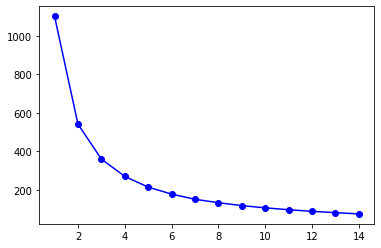

In [24]:
plt.plot(range(1,15),inertia1,'bo-');

**From the Elbow plot we can conclude that the optimized k is 3. So we will take 3 clusters here.**

In [25]:
%%time
inertia1=[]
for Num_of_clusters in range(1):
    ### TO initialize the centroids
    sum_of_jaccard_for_wordID={}
    for i in jaccard_matrix:
        sum_of_jaccard_for_wordID[i]=sum(jaccard_matrix[i].values())
    ### Taking highest 10 sums
    max_10_sum=sorted(list(sum_of_jaccard_for_wordID.values()),reverse=True)[:3] ## Taking 3 cluster here
    initial_centroid=[]
    for j in jaccard_matrix:
        if sum_of_jaccard_for_wordID[j] in max_10_sum:
            initial_centroid.append(j)
    #print(initial_centroid)
    #print(sum_of_jaccard_for_wordID) 
    
    cluster=cluster_func1(initial_centroid)
    prev_centroids=initial_centroid
    new_centroids=[]
    for itr in range(10):
        if prev_centroids==new_centroids:  ## If the centroids are not changing then we won't iterate more.
            break
        prev_centroids=new_centroids
        prev_cluster=list(cluster.keys())
        new_centroids=[]
        for i in prev_cluster:
            cluster_element=cluster[i]
            total=[0]*(len(df)+1)
            for j in cluster_element:
                total += dic[j]       ### Adding up all list of a cluster
            avg = [x / len(cluster_element) for x in total]  ## Now we will get some fractional value
            for k in range(len(avg)):   ### Converting it only in 0 or 1
                if avg[k]>=0.05:
                    avg[k]=1
                else:
                    avg[k]=0
            elements=[]           ### Storing the wordID for that centroid of the cluster
            for l in range(len(avg)):
                if avg[l]==1:
                    elements.append(l)
    ### Now we will check which docID has best similarity with the calculated centroid.
    ### Best similarity docID wil be our new centroid
            min_index=np.inf
            center=-1
            for m in cluster_element:
                jac=jaccard_distance(D[m],elements)
                if jac<min_index:
                    min_index=jac
                    center=m
            new_centroids.append(center)
        cluster=cluster_func1(new_centroids)
        
    print(new_centroids)
    print(cluster)
    s=0
    for i in new_centroids:
        for j in cluster[i]:
            s=s+ jaccard_matrix[i][j]**2
    s=s/len(new_centroids) 
    inertia1.append(s)

[2, 1, 3]
{2: [2, 5, 8, 9, 16, 20, 22, 24, 25, 26, 27, 28, 31, 32, 36, 37, 39, 40, 42, 43, 47, 48, 49, 50, 51, 53, 54, 59, 60, 62, 63, 68, 69, 71, 72, 73, 75, 79, 81, 83, 84, 85, 86, 90, 91, 93, 94, 95, 96, 97, 99, 100, 101, 102, 105, 111, 112, 113, 114, 115, 119, 120, 121, 122, 124, 128, 135, 139, 140, 141, 143, 145, 149, 151, 155, 159, 161, 165, 166, 169, 170, 171, 174, 176, 178, 179, 180, 181, 182, 183, 184, 187, 188, 189, 190, 191, 192, 194, 195, 198, 200, 208, 210, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 227, 228, 233, 238, 246, 247, 248, 257, 259, 261, 262, 263, 264, 267, 269, 271, 276, 277, 278, 279, 281, 282, 283, 288, 292, 295, 298, 299, 301, 303, 305, 308, 309, 311, 312, 313, 314, 315, 318, 319, 320, 324, 333, 337, 339, 343, 344, 345, 346, 347, 348, 350, 351, 352, 353, 355, 356, 357, 358, 359, 360, 362, 377, 378, 382, 384, 386, 387, 388, 390, 391, 392, 393, 395, 396, 399, 402, 404, 407, 411, 415, 418, 419, 420, 421, 422, 423, 425, 426, 430, 431, 434, 